# 07.05 - Modeling - Prophet + Support Vector Regression

## Imports & setup

In [1]:
import pathlib
import warnings
from datetime import datetime
import sys
import pickle
import joblib
import gc

import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


# Imports
sys.path.append("..")
from src.utils.utils import (AnnualTimeSeriesSplit,
                             RollingAnnualTimeSeriesSplit,
                             bound_precision,
                             run_cross_val,
                             run_data_split_cross_val,
                             save_run_results)
from src.features.features import CyclicalToCycle
from src.models.models import SK_SARIMAX, SK_Prophet, SetTempAsPower, SK_Prophet_1
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         resids_vs_preds_plot)
#b # Packages
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from fbprophet import Prophet
from xgboost.sklearn import XGBRegressor

# Display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
figsize=(15,7)
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Data
PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
MODELS_DIR = PROJECT_DIR / 'data' / 'models'
RESULTS_PATH = PROJECT_DIR / 'data' /'results' / 'results.csv'

## Load Daily Data & Inspect

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
X = df.copy(deep=True)
X = X.loc['1994': '2008']
y = X.pop('daily_peak')
X.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0


In [4]:
y.tail()

2008-09-29    18338.0
2008-09-30    17977.0
2008-10-01    18168.0
2008-10-02    18256.0
2008-10-03    17495.0
Name: daily_peak, dtype: float64

## Prophet Model + XGBoost Residuals Model

In [5]:
N_SPLITS = 10
from sklearn.svm import SVR

def run_model(X,y, param=None):

    scores_dicts = {'train':
                        {'mae': [],
                         'bound': []},
                    'test':
                        {'mae': [],
                         'bound': []}}
    
    # Pre-processing
    # Robust Scaling
    robust_scaler_cols = ['hmdxx_min', 'hmdxx_max', 'hmdxx_median-1', 'temp_min','temp_max',
                          'dew_point_temp_max', 'visibility_mean']
    # Cyclical Transform
    rscaler = SelectiveRobustScaler(cols=robust_scaler_cols, trans_col_name=robust_scaler_cols)
    cyclical0 = CyclicalToCycle(cycle_name='hmdxx_max_hour', periods_per_cycle=24)
    cyclical1 = CyclicalToCycle(cycle_name='sun_rise', periods_per_cycle=24)
    cyclical2 = CyclicalToCycle(cycle_name='sun_set', periods_per_cycle=24)
    cyclical3 = CyclicalToCycle(cycle_name='day_of_week', periods_per_cycle=24)
    cyclical4 = CyclicalToCycle(cycle_name='week_of_year', periods_per_cycle=24)
    
    # Prophet
    factor = 0.05
    seas_factor = 0.05
    mode = 'multiplicative'
    regressors = {'hmdxx_min': (factor, False, mode),
                  'hmdxx_max': (factor, False, mode),
                  'hmdxx_median-1': (factor, False, mode),
                  'sin_hmdxx_max_hour': (seas_factor, False, mode),
                  'cos_hmdxx_max_hour': (seas_factor, False, mode),
                  'temp_min': (factor, False, mode),
                  'temp_max': (factor, 'auto', mode),
                  'dew_point_temp_max': (factor, False, mode),
                  'sin_sun_rise': (factor, False, mode),
                  'cos_sun_rise': (factor, False, mode),
                  'sin_sun_set': (factor, False, mode),
                  'cos_sun_set': (factor, False, mode),
                  'sin_day_of_week': (factor, False, mode),
                  'cos_day_of_week': (factor, False, mode),
                  'sin_week_of_year': (factor, False, mode),
                  'cos_week_of_year': (factor, False, mode),
                  'visibility_mean': (factor, False, mode),
                  'day_type': (factor, False, mode)}

    prophet_model = SK_Prophet_1(regressors=regressors,
                           pred_periods=96)


    # Residuals model
    resid_model = SVR(kernel='poly', C=100, gamma='auto', degree=5, epsilon=.1, coef0=1)


    ratscv = RollingAnnualTimeSeriesSplit(n_splits=N_SPLITS, goback_years=5)

    for train_indces, test_indces in ratscv.split(X, y):       
        X_train = X.iloc[train_indces]; y_train = y.iloc[train_indces]
        X_test = X.iloc[test_indces] ; y_test = y.iloc[test_indces]

        # Pre-processing Cyclic features
        cyclical0.fit(X_train, y_train)
        X_t_train = cyclical0.transform(X_train)
        X_t_test = cyclical0.transform(X_test)
        
        cyclical1.fit(X_t_train, y_train)
        X_t_train = cyclical1.transform(X_t_train)
        X_t_test = cyclical1.transform(X_t_test)
        
        cyclical2.fit(X_t_train, y_train)
        X_t_train = cyclical2.transform(X_t_train)
        X_t_test = cyclical2.transform(X_t_test)

        cyclical3.fit(X_t_train, y_train)
        X_t_train = cyclical3.transform(X_t_train)
        X_t_test = cyclical3.transform(X_t_test)
        
        cyclical4.fit(X_t_train, y_train)
        X_t_train = cyclical4.transform(X_t_train)
        X_t_test = cyclical4.transform(X_t_test)
        
        # Pre-processing Robust Scaler
        rscaler.fit(X_t_train, y_train)
        X_t_train = rscaler.transform(X_t_train)
        X_t_test = rscaler.transform(X_t_test)

        # LH Initial y Prediction
        prophet_model.fit(X_t_train, y_train)
        y_hat_train = prophet_model.predict(X_t_train)
        y_hat_test = prophet_model.predict(X_t_test)

        # LH Get Residuals
        r_train = y_train - y_hat_train
        r_test = y_test - y_hat_test

        # LH Fit & Predict Residuals
        resid_model.fit(X_t_train, r_train)
        r_hat_train = resid_model.predict(X_t_train)
        r_hat_test = resid_model.predict(X_t_test)

        # LH Adder - Add Residual Prediction to Initial y Prediction
        y_hat_plus_train = y_hat_train + r_hat_train
        y_hat_plus_test = y_hat_test + r_hat_test

        mae_train = mean_absolute_error(y_train, y_hat_plus_train)
        mae_test = mean_absolute_error(y_test, y_hat_plus_test)
        bound_prec_train = bound_precision(y_train, y_hat_plus_train)
        bound_prec_test = bound_precision(y_test, y_hat_plus_test)
        
        scores_dicts['train']['mae'].append(mae_train)
        scores_dicts['train']['bound'].append(bound_prec_train)
        scores_dicts['test']['mae'].append(mae_test)
        scores_dicts['test']['bound'].append(bound_prec_test)
        
    # Use the time series pred vals DataFrame as a template
    pred_vals = prophet_model.get_pred_values()
    for col in pred_vals.columns:
        # Leave the is_forecast in place to tell the plot functions the train/test split
        if col != 'is_forecast':
            pred_vals[col] = np.NaN
    # Fill in the values for y
    pred_vals.loc[y_train.index, 'y'] = y_train.values
    pred_vals.loc[y_test.index, 'y'] = y_test.values
    # Replace the Time Series Models predictions with the
    # combined prediction values
    pred_vals.loc[y_hat_plus_train.index, 'yhat'] = y_hat_plus_train.values
    pred_vals.loc[y_hat_plus_test.index, 'yhat'] = y_hat_plus_test.values
    # Calculate the residuals
    pred_vals['resid'] = pred_vals['y'].subtract(pred_vals['yhat'])
    # Elimanate the obsolete columns such as confidence intervals
    pred_vals = pred_vals[['y', 'yhat', 'resid', 'is_forecast']]

    return pred_vals, scores_dicts

In [6]:
pred_vals, d = run_model(X, y)
print(d)
print('Train')
print(np.mean(d['train']['mae']))
print(np.mean(d['train']['bound']))
print('Test')
print(np.mean(d['test']['mae']))
print(np.mean(d['test']['bound']))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
{'train': {'mae': [247.95886455026277, 289.1827661398472, 283.48631438114717, 298.5908014779914, 315.0952464612801, 337.55550605891943, 318.30678478810586, 328.56821244719373, 332.22267571047234, 336.107147187541], 'bound': [0.4, 0.8, 1.0, 1.0, 0.4, 0.6, 0.6, 0.4, 0.4, 0.4]}, 'test': {'mae': [560.3620953084337, 362.055639543277, 454.83189471727763, 481.7261850269089, 795.1897462712037, 611.7349436558217, 751.0813536830856, 934.5637438952446, 519.7149023542479, 457.26353996957596], 'bound': [0.8, 1.0, 0.8, 0.6, 0.6, 0.8, 0.2, 1.0, 0.8, 0.6]}}
Train
308.70743192027606
0.6000000000000001
Test
592.8524044425076
0.72


In [7]:
pred_vals

,y,yhat,resid,is_forecast
2003-05-20,18599.0,18150.619921,448.380079,0
2003-05-21,17622.0,17784.223533,-162.223533,0
2003-05-22,17662.0,17662.099893,-0.099893,0
2003-05-23,17713.0,17713.099300,-0.099300,0
2003-05-26,17990.0,18256.683499,-266.683499,0
...,...,...,...,...
2008-09-29,18338.0,18412.945286,-74.945286,1
2008-09-30,17977.0,18231.101820,-254.101820,1
2008-10-01,18168.0,18127.919071,40.080929,1
2008-10-02,18256.0,18245.497906,10.502094,1


### Review the last model run in the Cross Validation

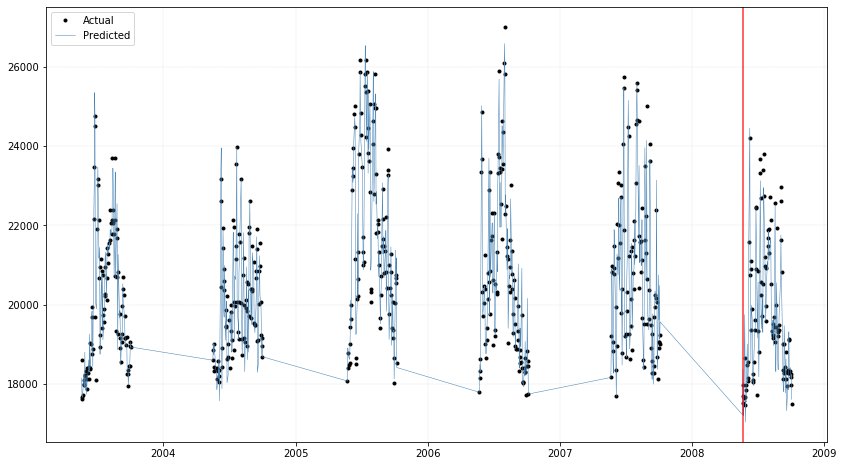

In [8]:
fig, ax = plot_prediction(pred_vals, goback_years=20)
plt.show();

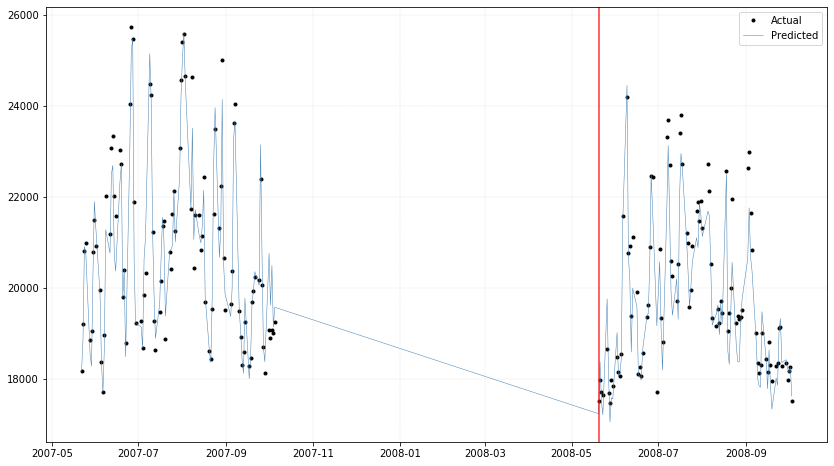

In [9]:
fig, ax = plot_prediction(pred_vals, goback_years=2)
plt.show();

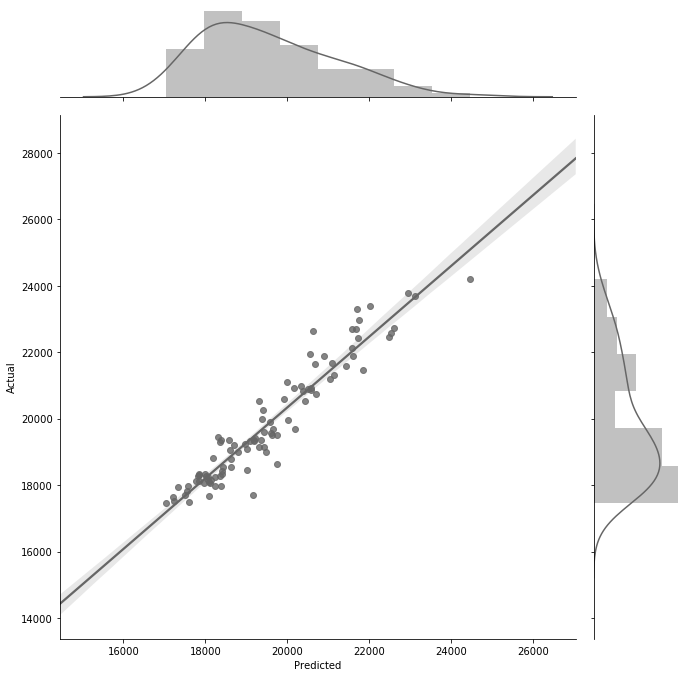

In [10]:
fig, ax = plot_joint_plot(pred_vals, goback_years=1)
plt.show();

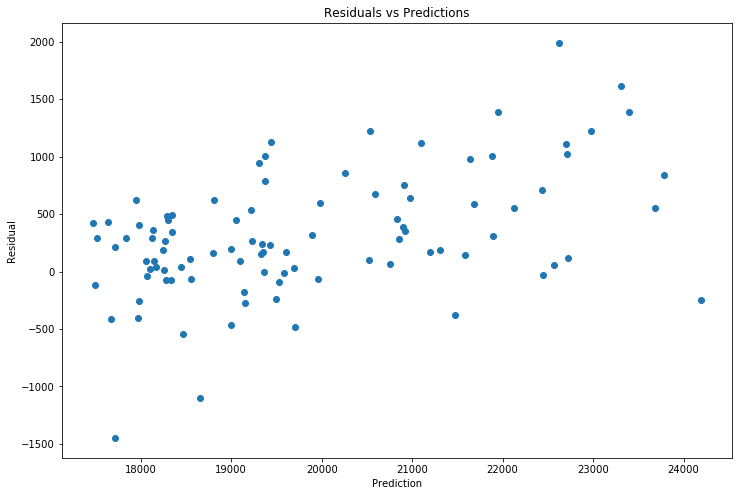

In [11]:
fig, ax = resids_vs_preds_plot(pred_vals)
plt.show()

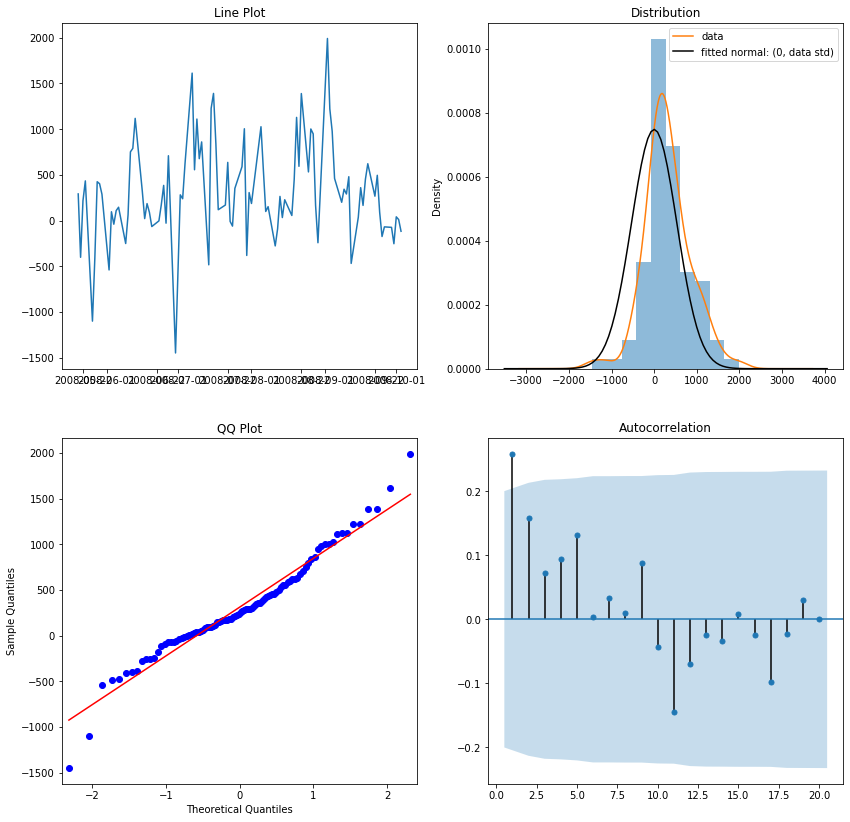

In [12]:
fig, ax = residual_plots(pred_vals)
plt.show()

In [13]:
print_residual_stats(pred_vals)

LJung Box Corr p value:		0.19468
Jarque Bera Normal p value:	0.01888


In [14]:
df = save_run_results(X, N_SPLITS, 'Prophet + SVR', d, RESULTS_PATH)
df

Baseline                      Prophet                 Prophet + XGBoost       Prophet + SVR      
              mae bound_precision          mae bound_precision               mae bound           mae bound
1999   785.341009             0.6   720.218501             0.8        564.413176   0.8    560.362095   0.8
2000   841.496643             0.8   538.393316             0.8        388.030452   0.8    362.055640   1.0
2001   971.010973             0.6   730.275530             1.0        521.176514   1.0    454.831895   0.8
2002  1120.417756             0.4   712.523997             0.4        509.309746   0.6    481.726185   0.6
2003  1576.417824             0.6   938.619116             0.6        837.172955   0.4    795.189746   0.6
2004  1447.394438             0.6   605.586615             0.8        635.993295   0.8    611.734944   0.8
2005  1137.307718             0.2   982.040388             0.2        768.483651   0.2    751.081354   0.2
2006  1502.960994             0.8  1038.864989             1.0        894.626531   1.0    934.563744   1.0
2007  2523.435378             0.6   660.926417             0.8        518.663409   0.8    519.714902   0.8
2008  2433.310031             0.8   606.042829             0.6        477.396795   0.6    457.263540   0.6